# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
from glob import glob
import datetime
import PIL
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras import layers

# Data Load

In [2]:
data_path = "C:\\Users\\user\\Desktop\\open"

train_folder = os.path.join(data_path, "train")
label_list = list(os.listdir(train_folder))
label_dict = {}
for i in range(len(label_list)):
    label_dict[label_list[i]] = i
label_dicts = {v:k for k,v in label_dict.items()}

all_img_path = glob(os.path.join(train_folder,"*","*"))

In [3]:
width = 400
height = 400

In [4]:
X = []
y = []
for img in tqdm(all_img_path):
    image = PIL.Image.open(img)
    image = image.resize((width,height))
    image = np.array(image)
    X.append(image)
    label = img.split('\\')[-2]
    label = label_dict[label]
    y.append(label)

  0%|          | 0/3457 [00:00<?, ?it/s]

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2,shuffle=True,random_state=530)

In [7]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(2765, 400, 400, 3)
(2765,)
(692, 400, 400, 3)
(692,)


# Configure Hyperparameters

In [8]:
num_classes = len(label_list)
input_shape = (width,height,3)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 4
num_epochs = 10
image_size = width  # We'll resize input images to this size
patch_size = 40  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 32
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 32
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Data Augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_X)

# Implement Multi-Layer Perceptron (MLP)

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Implement Patch creation as a Layer

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 400 X 400
Patch size: 40 X 40
Patches per image: 100
Elements per patch: 4800


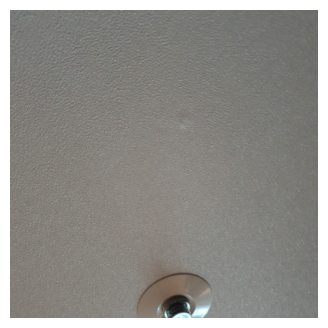

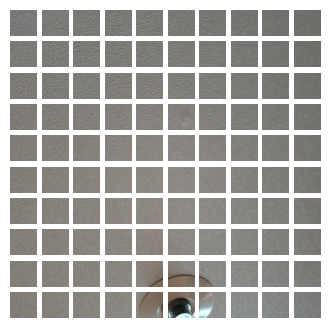

In [12]:
# display patches for a sample image
plt.figure(figsize=(4, 4))
image = train_X[np.random.choice(range(train_X.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# Implement the Patch Encoding Layer

In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Build ViT Model

In [14]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Compile, Train, Evaluate the Model

In [15]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=train_X,
        y=train_y,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_X, test_y)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [16]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/10
622/622 [==============================] - 3125s 5s/step - loss: 4.8557 - accuracy: 0.2637 - top-5-accuracy: 0.6499 - val_loss: 2.0048 - val_accuracy: 0.3899 - val_top-5-accuracy: 0.7762
Epoch 2/10
622/622 [==============================] - 3363s 5s/step - loss: 2.3524 - accuracy: 0.3368 - top-5-accuracy: 0.7367 - val_loss: 2.0699 - val_accuracy: 0.4296 - val_top-5-accuracy: 0.7076
Epoch 3/10
622/622 [==============================] - 2054s 3s/step - loss: 2.2869 - accuracy: 0.3533 - top-5-accuracy: 0.7428 - val_loss: 2.0858 - val_accuracy: 0.3610 - val_top-5-accuracy: 0.7942
Epoch 4/10
622/622 [==============================] - 2121s 3s/step - loss: 2.2956 - accuracy: 0.3641 - top-5-accuracy: 0.7347 - val_loss: 2.0179 - val_accuracy: 0.4079 - val_top-5-accuracy: 0.8123
Epoch 5/10
622/622 [==============================] - 1924s 3s/step - loss: 2.1922 - accuracy: 0.3645 - top-5-accuracy: 0.7605 - val_loss: 2.1338 - val_accuracy: 0.3032 - val_top-5-accuracy: 0.8195
Epoch 6/10

# Predict

In [17]:
test_imgs = glob(os.path.join(data_path,"test","*"))
pred_imgs = []
for i in tqdm(range(len(test_imgs))):
    pred_img = PIL.Image.open(test_imgs[i])
    pred_img = pred_img.resize((width,height))
    pred_img = np.array(pred_img)
    pred_imgs.append(pred_img)

pred_imgs = np.array(pred_imgs)

  0%|          | 0/792 [00:00<?, ?it/s]

In [18]:
predictions = vit_classifier.predict(pred_imgs)

In [19]:
pred_labels = []
for i in tqdm(range(len(predictions))):
    prediction = predictions[i]
    pred_label = int(np.argmax(prediction))
    pred_labels.append(pred_label)

real_labels = []
for i in tqdm(range(len(pred_labels))):
    pred_label = int(pred_labels[i])
    real_label = label_dicts.get(pred_label)
    real_labels.append(real_label)

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]